# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [41]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [42]:
# Your work here.
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


 ## 1. Is the Distribution of Body Temperatures approximately normal?

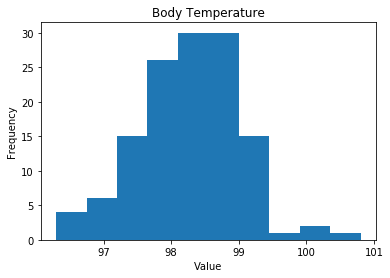

In [43]:
import matplotlib.pyplot as plt

plt.hist(df['temperature'])
plt.title('Body Temperature')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()


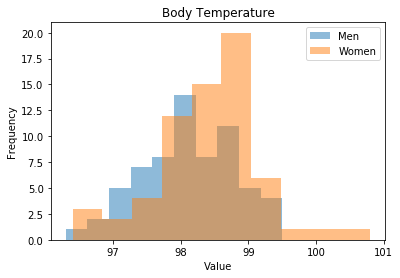

In [44]:
men = df.loc[df['gender'] == 'M']
women = df.loc[df['gender'] == 'F']

plt.hist(men['temperature'], alpha = .5, label = 'Men')
plt.hist(women['temperature'], alpha = .5, label = 'Women')
plt.title('Body Temperature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

It is unclear whether the distribution is normal from our histogram alone. The distribution shows an approximately normal shape, but there does also appear to be a second mode in the right tail. 

When we color our histogram by sex we see that this long right tails is comprised mostly of Female body temperatures, with the male distribution exhibiting a more normal shape.

We will perform a Shapiro-Wilk test to determine whether normality exists under a more objective standard.

We are testing the null hypothesis that our data is sampled from a population that has a normal distribution at alpha level .05:

In [45]:
import scipy.stats
import plotly.plotly as py

In [46]:
#test for all data
shapiro_results = scipy.stats.shapiro(df['temperature'])

summaryDf = pd.DataFrame({'Samples': len(df['temperature']) - 1, \
                          'Test Statistic':shapiro_results[0], \
                          'P-Value': shapiro_results[1]}, index = [0])

summaryDf

,P-Value,Samples,Test Statistic
0,0.233168,129,0.986577


In [47]:
#test for men
shapiro_results = scipy.stats.shapiro(men['temperature'])

summaryDf = pd.DataFrame({'Samples': len(men['temperature']) - 1, \
                          'Test Statistic':shapiro_results[0], \
                          'P-Value': shapiro_results[1]}, index = [0])

summaryDf

,P-Value,Samples,Test Statistic
0,0.854517,64,0.989407


In [48]:
#test for women
shapiro_results = scipy.stats.shapiro(women['temperature'])

summaryDf = pd.DataFrame({'Samples': len(women['temperature']) - 1, \
                          'Test Statistic':shapiro_results[0], \
                          'P-Value': shapiro_results[1]}, index = [0])

summaryDf

,P-Value,Samples,Test Statistic
0,0.090166,64,0.967975


Our Null hypothesis was that the population is normally distributed. As our P-value is higher than our chosen p-value of .05, we fail to reject the null hypothesis that the population is normally distributed.

**Conclusion:** The distribution is approximately normal.

## 2. Is the Sample Size Large? Are the observations independent? 

In [49]:
df['temperature'].mean()

98.24923076923078

Sample sizes above 30 are generally considered large enough for the CLT to apply. Even if we split the We also noted above that the distribution is approximately normal, and that our sample mean is reasonably close to the population mean of 98.6. As such, we can be comfortable that the sample size is large enough for analysis. 

**Conclusion:** The sample size is large enough for our analysis.

## 3. Is the true population mean really 98.6 degrees F? 

Our null hypothesis is that the mean body temperature for human beings is 98.6 degrees.

**Bootstrap Method Test:**

Our bootstrap will answer the following question -- could we have obtained the dataset we did, if the true population mean is equal to the Wunderlich mean of 98.6 degrees and not 98.2 degrees (as calculated above). We will therefore simulate a situation in which the true mean body temperature is equal to 98.6. We will take the following steps:

 1. Shift our data to match the Wunderlich mean.
 2. Our **test statistic** is the bootstrap mean minus Wunderlich's mean.
 3. Then we will use a function to draw bootstrap replicates of this mean deviation.
 4. Calculate a p-value - the fraction of bootstrap replicates that are less than the observed test statistic.
 
This is a **one-sample** test because we are comparing one set of data to a single number.

In [50]:
import numpy as np

#generate functions for anlysis

#generate replicate function
def bootstrap_replicate_1d(data, func):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

#draw replicates function
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

#calculatetemp difference
def tempDiff(data, wunderlich = 98.6):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data) - wunderlich

    return diff

def meanDiff(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [51]:
#Execute Test

#1. Shift our data to match the Wunderlich Mean
df['rateShift'] = df['temperature'] - np.mean(df['temperature']) + 98.6

#2. Calculate Test statitic
testStat = tempDiff(df['temperature'])

#3. Use a function to draw bootstrap replicates of this mean deviation.
bs_replicates = draw_bs_reps(df['rateShift'], tempDiff, 100000)

#4. Calculate p-value - proportion of data equal to or less than observed difference
p = np.sum(bs_replicates <= testStat) / 100000

# Print the p-value
print('p = ', p, 'test stat:', testStat)

p =  0.0 test stat: -0.35076923076921673


We found that none of our bootstrap sample populations showed a mean deviation less than or equal to our test statistic of -.35. As such, we can reject the null hypothesis that our mean temperature is 98.6 degrees for this population.

**Frequentist Test**

We will perform a z-test and a t-test to assess whether our population mean is statisticall different from 98.6. As our sample size is greater than 30, a z-test is generally thought of as more appropriate in this situation.

In [52]:
#ztest
import statsmodels.api as sm

testStat, p = sm.stats.ztest(x1 = df['temperature'], x2 = None, \
                             value = 98.6, alternative = 'two-sided')

print('p = ', p, 'test stat:', testStat)

p =  4.9021570141012155e-08 test stat: -5.4548232923645195


**Conclusion:** As our p-value is below .05, we reject our null hypothesis that the population mean is equal to 98.6 degrees.

In [53]:
#ttest
from scipy import stats

testStat, p =stats.ttest_1samp(df['temperature'], 98.6)

print('p = ', p, 'test stat:', testStat)

p =  2.4106320415561276e-07 test stat: -5.4548232923645195


**Conclusion:** As our p-value is below .05, we reject our null hypothesis that the population mean is equal to 98.6 degrees.

 ## 4. Draw a small sample of size 10 from the data and repeat both frequentist tests. 
 
 An t-test is considered preferable in this situation because the sample size is less than 30.


In [54]:
sample = df.sample(10)

In [55]:
#ztest
import statsmodels.api as sm

testStat, p = sm.stats.ztest(x1 = sample['temperature'], x2 = None, \
                             value = 98.6, alternative = 'two-sided')

print('p = ', p, 'test stat:', testStat)

p =  0.004114121292699342 test stat: -2.8692763818330453


In [56]:
#ttest
from scipy import stats

testStat, p =stats.ttest_1samp(sample['temperature'], 98.6)

print('p = ', p, 'test stat:', testStat)

p =  0.01849850428338945 test stat: -2.8692763818330453


**Conclusion:** As our p-value is below .05, we reject our null hypothesis using both the ztest and the t test. We note that our p-value is higher for the t test. The t-distribution assumes a fatter tailed distribution, which makes it less likely that we identify a given mean deviation as low probability.

**Bootstrapped**

In [57]:
bs_replicates = draw_bs_reps(df['temperature'], np.mean, 100000)
print('A body temperature above ', np.percentile(bs_replicates, 95),\
      'or below ',  np.percentile(bs_replicates, 5), ' is statistically abnormal')

A body temperature above  98.35384615384615 or below  98.14384615384616  is statistically abnormal


**Frequentist:**

In [58]:
def meanConfidenceInterval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t._ppf((1+confidence)/2., n-1)
    return m-h, m+h

In [59]:
meanConfidenceInterval(df['temperature'])

(98.12200290560801, 98.37645863285348)

In [60]:
df.loc[df['gender'] == 'M', 'temperature']

2      97.8
5      99.2
6      98.0
7      98.8
12     98.2
17     98.2
19     99.4
21     98.2
22     98.6
23     98.4
24     97.8
29     98.1
30     98.3
32     98.5
33     98.6
34     99.3
35     99.5
36     99.1
37     98.3
41     98.4
42     96.9
43     97.2
46     97.4
47     97.4
48     97.9
49     97.1
53     98.6
57     98.2
59     97.6
61     98.4
       ... 
73     98.8
74     99.0
75     98.8
77     98.4
78     97.4
79     97.6
81     98.0
82     97.5
85     97.1
87     98.0
88     98.7
89     98.1
90     97.8
93     97.1
94     97.8
99     98.0
100    99.0
101    98.5
104    97.6
105    96.7
106    97.0
107    98.6
109    97.3
114    99.0
115    98.0
118    98.7
124    97.5
125    96.3
126    97.7
128    97.9
Name: temperature, Length: 65, dtype: float64

In [61]:
# Compute objects
meanTemp = np.mean(df['temperature'])
m = df.loc[df['gender'] == 'M', 'temperature']
meanM = df.loc[df['gender'] == 'M', 'temperature'].mean()
w = df.loc[df['gender'] == 'F', 'temperature']
meanW = df.loc[df['gender'] == 'F', 'temperature'].mean()
meanDiffs = meanDiff(m, w)

# Generate shifted arrays
menShifted = m - meanM + meanTemp
womenShifted = w - meanW + meanTemp

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_m = draw_bs_reps(menShifted, np.mean, 10000)
bs_replicates_w = draw_bs_reps(womenShifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_m - bs_replicates_w

# Compute and print p-value: p
p = np.sum(bs_replicates > meanDiffs) / 10000
print('p-value =', p)


p-value = 0.9897


**Conclusion:** There is not a statistically significant difference between male and female body temperature.